In [6]:
import numpy as np
import os
from dipy.io.streamline import load_trk
from dipy.viz import window, actor
import math
from nibabel import trackvis as tv
from dipy.tracking.streamline import Streamlines
from dipy.segment.clustering import QuickBundles
from dipy.io.pickles import save_pickle
from dipy.io.pickles import load_pickle
from dipy.data import get_data
from dipy.segment.metric import mdf
from dipy.segment.metric import AveragePointwiseEuclideanMetric
import matplotlib.pyplot as plt
import pickle
from dipy.io.streamline import load_trk, save_trk
import nibabel
import vtk

In [7]:
def show_streamlines(streamlines): #function to visualize streamlines
    
    ren = window.Renderer()
    ren.add(actor.line(streamlines))
    window.show(ren)

In [8]:
def show_two_streamlines(streamline1,streamline2): #function to visualize streamlines
    
    ren = window.Renderer()
    ren.add(actor.line(streamline1))
    ren.add(actor.line(streamline2,colors=(0,1,1), linewidth=10))
    window.show(ren)

In [100]:
def show_multiple_streamlines(streamlines, noOfCentroids=0): #function to visualize streamlines
    
    ren = window.Renderer()
    if(noOfCentroids==0):
        noOfCentroids = -(len(streamlines))
#     centroidsList
    for i,s in enumerate(streamlines[:-noOfCentroids]):
        print(i*(255/(len(streamlines)-1)))
        ren.add(actor.line(s, colors = (0,i,1)))
    for i in range(noOfCentroids):
        ren.add(actor.line(streamlines[-i-1],colors=(1,0,1), linewidth=10))
#     for cent in centroidsList:
#         ren.add(actor.line(cent, colors = (0,1,0), linewidth=1))
    window.show(ren)

In [58]:
# AFL, afl_hr = load_trk("data/AF_L.trk")

In [51]:
# import glob, os
# def tck_to_trk(location):
#     path = os.getcwd()

#     os.chdir(path+"/"+location)
#     all_files = os.listdir()
#     all_files.sort(reverse=True)
# #     print(all_files)
#     print(os.getcwd())

#     file = nibabel.streamlines.load(all_files[0])
#     whole_brain = file.streamlines
#     for i in range(1, len(all_files)):
#         if all_files[i][0]!='.':
#             print(all_files[i])
#             file = nibabel.streamlines.load(all_files[i])
#             save_trk("trk/"+all_files[i][:-4]+".trk",file.streamlines, np.eye(4))
# #             whole_brain.extend(file.streamlines)

# #     direc = path+location+"/data/"+location
# #     os.makedirs(direc)
# #     file = nibabel.streamlines.load("AF_left.tck")
# #     os.chdir(direc)
# #     save_trk("brain.trk", whole_brain, np.eye(4))
# #     save_trk("AF_L.trk",file.streamlines, np.eye(4))

#     os.chdir(path)

In [12]:
# file = nibabel.streamlines.load("data/bundles1")
# tck_to_trk("data/12/2")


In [13]:
os.getcwd()

'/Users/rp7/Documents/FiberBundles'

In [14]:
from dipy.align.streamlinear import set_number_of_points
def getCentroids(streamlines, noOfCentroids, pointsInCentroid=20):
    streamlines = [set_number_of_points(streamline, nb_points=pointsInCentroid) for streamline in streamlines]
    thresh=1
    qb = QuickBundles(threshold=thresh, metric=AveragePointwiseEuclideanMetric())
    clusters = qb.cluster(streamlines)
    length = len(clusters.centroids)
    prev = 0
    flag=False
    while(length!=noOfCentroids):
        if(length>noOfCentroids):
            if flag:
                temp = thresh
                thresh= thresh + (thresh-prev)/2.0
                prev = temp
            else:
                prev=thresh
                thresh *= 2.0
        else:
            temp = thresh
            thresh = prev+(thresh-prev)/2.0
            flag = True
        qb = QuickBundles(threshold=thresh, metric=AveragePointwiseEuclideanMetric())
        clusters = qb.cluster(streamlines)
        length = len(clusters)
    return np.array(clusters.centroids)

In [15]:
def tck_to_trk(location):
    os.mkdir(location+"/trk")
    for file in glob.glob1(os.getcwd()+"/"+location+"/", "*.tck"):
        tckBundle = nibabel.streamlines.load(location+"/"+file)
        save_trk(location+"/trk/"+file[:-4]+".trk",tckBundle.streamlines, np.eye(4))
        print("Converted "+file+" to trk")

In [16]:
def get_centroid_of_bundles(location, no_of_centroids, pointsInCentroid=400):
    centroids = []
    file_number = 1
    if("trk" not in os.listdir(location)):
        tck_to_trk(location)
    for file in sorted(glob.glob1(os.getcwd()+"/"+location+"/trk", "*.trk")):
        tckBundle = nibabel.streamlines.load(location+"/trk/"+file)
        save_trk(location+"/trk/"+file,tckBundle.streamlines, np.eye(4))
        bundle, bn_hr = load_trk(location+"/trk/"+file[:-4]+".trk")
        centroids.append(getCentroids(bundle, no_of_centroids, pointsInCentroid))
        print(file_number, file)
        file_number+=1
    
    return centroids
    

In [17]:
def get_mean_centroid_list(centroidsList):
    meanCentroidList = []
    for centroids in centroidsList:
        meanCentroidList.append([sum(x)/len(centroids) for x in zip(*centroids)])
    return meanCentroidList

In [18]:
def get_base_centroid_matrix(centroidsList):
    
    meanCentroidList = get_mean_centroid_list(centroidsList)
    base_distances = []
    for centroid1 in meanCentroidList:
        base_distances.append([])
        for centroid2 in meanCentroidList:
            base_distances[-1].append(mdf(np.array(centroid1), np.array(centroid2)))
            
    return base_distances

In [19]:
# Setup
reset = False

if not os.path.isfile("centroidsList.pkl") or reset:
    # Assume all the bundles in the folder are in the .trk format
    centroidsList = get_centroid_of_bundles("data/bundles1", 1)
    save_pickle("centroidsList.pkl", centroidsList)
else:
    centroidsList = load_pickle("centroidsList.pkl")

if not os.path.isfile("base_centroid_matrix.pkl") or reset:
    # (no of centroids x no of centroids)
    base_centroid_matrix = get_base_centroid_matrix(centroidsList)
    save_pickle("base_centroid_matrix.pkl", base_centroid_matrix)
else:
    base_centroid_matrix = load_pickle("base_centroid_matrix.pkl")

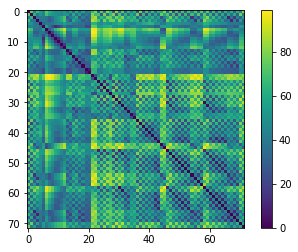

In [20]:
plt.imshow(base_centroid_matrix)
plt.colorbar()

In [21]:
# base_centroid_matrix

In [22]:
len(centroidsList[1][0]) 

400

In [23]:
def get_mdf_dists_to_centroids(streamline, centroidsList):
    distances = []
    for centroid in centroidsList:
        distances.append(mdf(streamline, centroid[0]))
    return distances

In [24]:
# Classify
def classify(streamline, centroidsList, base_centroid_matrix):
    vector_rep_of_streamline = get_mdf_dists_to_centroids(streamline, centroidsList)
    a = np.array(base_centroid_matrix)
    a = (a/np.sum(a,axis=1).reshape((-1,1)))
    b = np.array(vector_rep_of_streamline)
    b = b/np.sum(b)
#     print(a.shape,b.shape)
#     variation_in_mdf_dist = []
# mdf distances were coming too close, so not a good option
#     for i in range(a.shape[0]):
#         variation_in_mdf_dist.append(mdf(a[i,:].reshape((-1,1)), b.reshape((-1,1))))
    variation_in_mdf_dist = (a-b)**2
#     print((vector_rep_of_streamline))
#     return np.argmin(np.sum(variation_in_mdf_dist, axis=1))
    return np.argmin(vector_rep_of_streamline)

In [25]:
def testBundle(bundle, label, centroidsList, base_centroid_matrix):
    pred = []
    vis = Streamlines()
    for bund in bundle:
        pred.append(classify(bund, centroidsList, base_centroid_matrix))
        if(pred[-1]==2):
            vis.append(bund)
#     print(pred)
    return np.sum(pred==label)/len(label), np.sum(pred==label), vis

In [31]:
def getNBundles(location, N=False):
    files = os.listdir(location)
    files.sort()
    i=0
#     ren = window.Renderer()
#     visuals = Streamlines()
    bundles = Streamlines()
    for file in files:
        if file[-4:]==".trk" and (N==False or i<N):
            bundle, hr = load_trk(location+"/"+file)
            bundles.append(bundle)
            i+=1
    
    return bundles, files

In [85]:
def testAllLabels(location, N=False):
    final_accuracies = []
    i=0
#     ren = window.Renderer()
    visuals = Streamlines()
    
    bundles, fileNames = getNBundles(location, N)
    for bundle in bundles:
        accuracy, count, vis = testBundle(bundle, np.ones(len(bundle))*i, centroidsList, base_centroid_matrix)
        for val in vis:
            visuals.append(val)
        print(i, fileNames[i], accuracy, count, len(bundle))
        final_accuracies.append(accuracy)
#         if i==2:
#             show_multiple_streamlines([bundle[900:1000], visuals, getCentroids(bundles[0],1), getCentroids(bundles[1],1), getCentroids(bundles[2],1)])
#             break
        i+=1
    return final_accuracies, visuals, bundles

# print(classes)

In [101]:
accuracies, visuals, bundles = testAllLabels("data/bundles1/trk", 3)

0 AF_left.trk 0.916 1832 2000
1 AF_right.trk 0.01 20 2000
2 ATR_left.trk 0.007 14 2000


In [102]:
# (base_centroid_matrix[0]) #/np.sum(base_centroid_matrix[0])

In [112]:
show_multiple_streamlines([visuals[0:1], getCentroids(bundles[0],1), getCentroids(bundles[1],1), getCentroids(bundles[2],1)], 3)



0.0


In [129]:
print(mdf(np.array(visuals[0:1])[0], getCentroids(bundles[0],1)[0]))
print(mdf(np.array(visuals[1:2])[0], getCentroids(bundles[0],1)[0]))
print(mdf(np.array(visuals[2:3])[0], getCentroids(bundles[0],1)[0]))
print(mdf(np.array(visuals[3:4])[0], getCentroids(bundles[0],1)[0]))
print(mdf(np.array(visuals[4:5])[0], getCentroids(bundles[0],1)[0]))
print()
print(mdf(np.array(visuals[0:1])[0], getCentroids(bundles[1],1)[0]))
print(mdf(np.array(visuals[1:2])[0], getCentroids(bundles[1],1)[0]))
print(mdf(np.array(visuals[2:3])[0], getCentroids(bundles[1],1)[0]))
print(mdf(np.array(visuals[3:4])[0], getCentroids(bundles[1],1)[0]))
print(mdf(np.array(visuals[4:5])[0], getCentroids(bundles[1],1)[0]))
print()
print(mdf(np.array(visuals[0:1])[0], getCentroids(bundles[2],1)[0]))
print(mdf(np.array(visuals[1:2])[0], getCentroids(bundles[2],1)[0]))
print(mdf(np.array(visuals[2:3])[0], getCentroids(bundles[2],1)[0]))
print(mdf(np.array(visuals[3:4])[0], getCentroids(bundles[2],1)[0]))
print(mdf(np.array(visuals[4:5])[0], getCentroids(bundles[2],1)[0]))

nan
2.956313566151269e+31
nan
nan
3.0769598330832013e+31

nan
nan
2.746276118814491e+31
nan
nan

nan
nan
nan
2.2438567935588676e+31
nan


In [130]:
np.array(visuals[2:3])[0]

array([[ 63.74507  , -35.20888  ,  11.125823 ],
       [ 63.63363  , -35.218773 ,  11.18157  ],
       [ 63.522186 , -35.228664 ,  11.237317 ],
       ...,
       [ 39.21503  ,  -5.3473063,  16.01684  ],
       [ 39.286484 ,  -5.3612127,  15.915222 ],
       [ 39.357937 ,  -5.375119 ,  15.813606 ]], dtype=float32)

In [132]:
getCentroids(bundles[2],1)[0]

array([[-34.260723 ,  42.74503  ,   6.545764 ],
       [-31.937912 ,  40.873413 ,   6.494391 ],
       [-29.703987 ,  38.860363 ,   6.853879 ],
       [-27.651026 ,  36.599106 ,   7.630338 ],
       [-25.860338 ,  34.011665 ,   8.420388 ],
       [-24.358475 ,  30.910347 ,   8.769237 ],
       [-22.985231 ,  27.10969  ,   8.853612 ],
       [-21.950071 ,  22.800428 ,   9.209428 ],
       [-21.157148 ,  18.448967 ,   9.995279 ],
       [-20.359858 ,  14.162161 ,  10.8109455],
       [-19.401388 ,   9.946697 ,  11.333929 ],
       [-18.243649 ,   5.8317137,  11.32197  ],
       [-16.815317 ,   1.8686064,  10.7077465],
       [-15.195724 ,  -1.9197942,   9.541136 ],
       [-13.548118 ,  -5.5652256,   8.117338 ],
       [-11.913713 ,  -9.224972 ,   6.844097 ],
       [-10.313559 , -13.074545 ,   5.938854 ],
       [ -9.066357 , -17.137945 ,   5.304213 ],
       [ -8.528691 , -21.078163 ,   4.4892597],
       [ -8.845065 , -24.825766 ,   3.1647894]], dtype=float32)

In [36]:
v=np.array(visuals)

In [47]:
stv = Streamlines(v)

In [91]:
show_streamlines(visuals)

In [ ]:
bundle, hr = load_trk("data/bundles1/trk/AF_Left.trk")

In [44]:
bundle

ArraySequence([array([[-53.305935 , -66.66881  ,   6.0557475],
       [-53.23599  , -66.59657  ,   5.9814906],
       [-53.166042 , -66.52434  ,   5.9072337],
       ...,
       [-56.587444 ,  19.670176 ,  10.7102785],
       [-56.684296 ,  19.745266 ,  10.685651 ],
       [-56.781147 ,  19.820356 ,  10.661023 ]], dtype=float32), array([[-28.50829 ,  14.943563,  12.317939],
       [-28.5324  ,  14.829307,  12.362537],
       [-28.556559,  14.713767,  12.403669],
       ...,
       [-42.556988, -14.663528, -29.481146],
       [-42.508427, -14.606167, -29.581028],
       [-42.459866, -14.548805, -29.68091 ]], dtype=float32), array([[-43.94185 , -27.573772, -27.68087 ],
       [-43.971672, -27.650883, -27.587116],
       [-44.001495, -27.727993, -27.493362],
       ...,
       [-31.009892,  21.980625,  10.926019],
       [-31.013008,  22.092237,  10.869824],
       [-31.016125,  22.20385 ,  10.81363 ]], dtype=float32), ..., array([[-41.261456  , -62.89178   ,   6.778956  ],
       [-41.14

In [41]:
show_streamlines(stv)

/Users/rp7/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


TypeError: Could not find a suitable VTK type for object

In [35]:
# show_streamlines(visuals)
print(np.array(visuals)[:,0].shape)
st = Streamlines(np.array(visuals))
visuals
# show_streamlines(st)

(1698,)


[[array([[-53.305935 , -66.66881  ,   6.0557475],
         [-53.23599  , -66.59657  ,   5.9814906],
         [-53.166042 , -66.52434  ,   5.9072337],
         ...,
         [-56.587444 ,  19.670176 ,  10.7102785],
         [-56.684296 ,  19.745266 ,  10.685651 ],
         [-56.781147 ,  19.820356 ,  10.661023 ]], dtype=float32)],
 [array([[-28.50829 ,  14.943563,  12.317939],
         [-28.5324  ,  14.829307,  12.362537],
         [-28.556559,  14.713767,  12.403669],
         ...,
         [-42.556988, -14.663528, -29.481146],
         [-42.508427, -14.606167, -29.581028],
         [-42.459866, -14.548805, -29.68091 ]], dtype=float32)],
 [array([[-43.94185 , -27.573772, -27.68087 ],
         [-43.971672, -27.650883, -27.587116],
         [-44.001495, -27.727993, -27.493362],
         ...,
         [-31.009892,  21.980625,  10.926019],
         [-31.013008,  22.092237,  10.869824],
         [-31.016125,  22.20385 ,  10.81363 ]], dtype=float32)],
 [array([[-5.3130413e+01,  9.3800917e+00

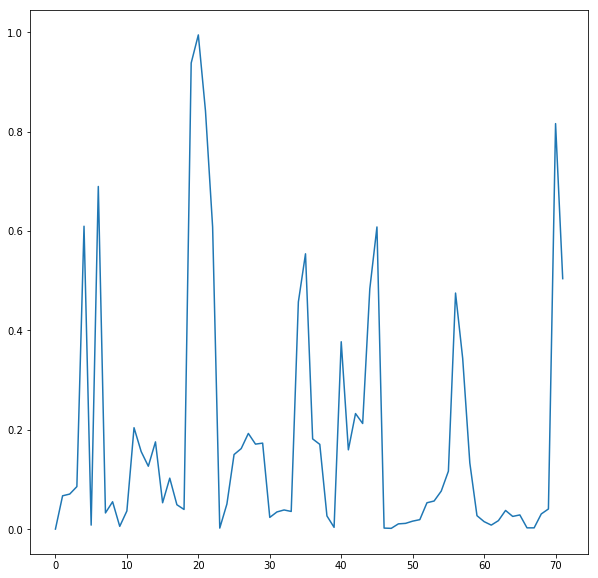

In [253]:
# squared error
plt.figure(figsize=(10,10))
plt.plot([0,0.067,0.0705,0.0855,0.6095,0.008,0.6895,0.0325,0.055,0.0055,0.0365,0.204,0.156,0.1265,0.1755,0.053,0.1025,0.049,0.0395,0.938,0.9945,0.8415,0.608,0.002,0.0505,0.15,0.162,0.1925,0.171,0.173,0.0235,0.0345,0.0385,0.0355,0.457,0.554,0.1815,0.1705,0.0265,0.0035,0.377,0.1595,0.2325,0.2125,0.4835,0.608,0.002,0.0015,0.0105,0.0115,0.016,0.019,0.053,0.0565,0.0765,0.1165,0.475,0.3435,0.133,0.027,0.015,0.008,0.017,0.0375,0.0255,0.0285,0.0025,0.0025,0.0305,0.0405,0.816,0.504])
plt.plot(accuracies)


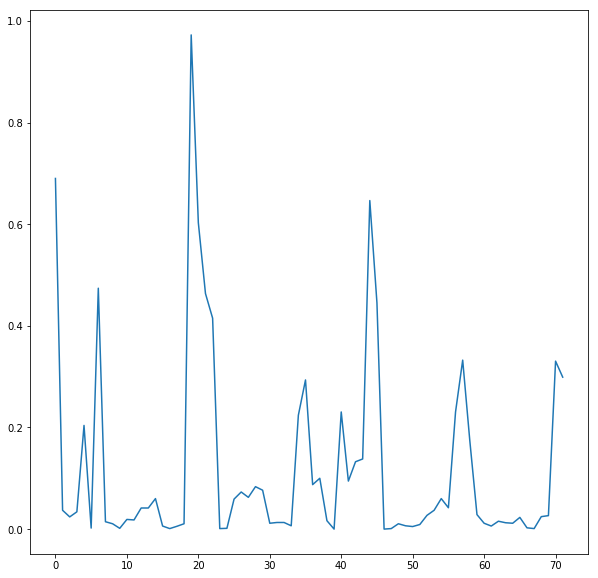

In [258]:
# absolute error
plt.figure(figsize=(10,10))
plt.plot(accuracies)

In [25]:
k=[]

In [26]:
l = [1,2,3]

In [27]:
k.append(l)

In [ ]:
k.append(l)

In [ ]:
k

In [53]:
s = Streamlines()

In [66]:
s.append([[1,2,3],[20,30,40]])

In [67]:
show_streamlines(s)